
Big thanks to louistiao: Plotting Bealy function http://louistiao.me/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/

More references:
- other animations:
    - Alex radfords animations http://www.denizyuret.com/2015/03/alec-radfords-animations-for.html

- functions:
    - Banana function: http://www.brnt.eu/phd/node10.html https://en.wikipedia.org/wiki/Rosenbrock_function
    - Func defs https://github.com/mattloper/chumpy/blob/master/chumpy/test_optimization.py


- pytorch beales func test https://github.com/april-org/april-ann/blob/0f7b1e823b57cfeac413fc6d910fd9c256817601/packages/ann/optimizer/test/test-beales-function.lua

- lura torch https://github.com/svecon/TorchPlayground/blob/fd3496f8390fc98eabfcfd02bddfec38ca432854/5_numerical_optimization.ipynb

In [46]:
%matplotlib inline

In [48]:
import matplotlib.pyplot as plt
# import numpy as np
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

In [49]:
def beales(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

f = beales

In [54]:
xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

In [55]:
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

In [56]:
z = f(x, y)

In [57]:
minima = np.array([3., .5])

In [58]:
minima_ = minima.reshape(-1, 1)
minima_

array([[ 3. ],
       [ 0.5]])

# anim

In [59]:
x0 = np.array([3., 4.])

In [60]:
func = value_and_grad(lambda args: f(*args))

In [61]:
res = minimize(func, x0=x0, method='Newton-CG',
               jac=True, tol=1e-20, callback=print)

[ 2.71113991  3.35161828]
[ 2.48008912  2.78955116]
[ 2.29965866  2.30123678]
[ 2.16373347  1.8756312 ]
[ 2.06741079  1.50235414]
[ 2.00766238  1.17079384]
[ 1.98485905  0.86972447]
[ 2.00511126  0.59071489]
[ 2.07692544  0.34891823]
[ 2.17857778  0.21644485]
[ 2.55966682  0.38003383]
[ 2.80228089  0.44954972]
[ 2.94477854  0.48765376]
[ 2.94564749  0.48601427]
[ 2.95359059  0.48810805]
[ 2.97113927  0.49269804]
[ 2.99870879  0.49976069]
[ 2.99999481  0.49999876]
[ 3.00000001  0.49999999]
[ 3.   0.5]
[ 3.   0.5]


In [62]:
def make_minimize_cb(path=[]):
    
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))

    return minimize_cb

In [63]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [64]:
class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(self, *paths, zpaths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        for line, path, zpath in zip(self.lines, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
        return self.lines

In [65]:
methods = [
    "CG",
#   "BFGS",
    "Newton-CG",
    "L-BFGS-B",
    "TNC",
    "SLSQP",
#   "dogleg",
#   "trust-ncg"
]

In [66]:
minimize_ = partial(minimize, fun=func, x0=x0, jac=True, bounds=[(xmin, xmax), (ymin, ymax)], tol=1e-20)

In [67]:
paths_ = defaultdict(list)
for method in methods:
    paths_[method].append(x0)

In [68]:
results = {method: minimize_(method=method, callback=make_minimize_cb(paths_[method])) for method in methods}

/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)
/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Newton-CG cannot handle constraints nor bounds.
  RuntimeWarning)


In [69]:
paths = [np.array(paths_[method]).T for method in methods]

In [70]:
zpaths = [f(*path) for path in paths]

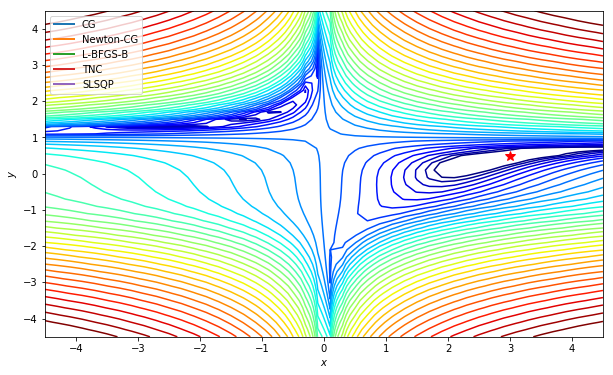

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [72]:
HTML(anim.to_html5_video())

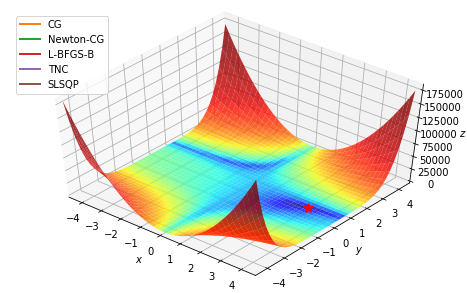

In [44]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation3D(*paths, zpaths=zpaths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [45]:
HTML(anim.to_html5_video())

# Misc

In [1]:


# def Rosen():
    
#     args = {
#         'x1': Ch(-120.),
#         'x2': Ch(-100.)
#     }
#     r1 = Ch(lambda x1, x2 : (x2 - x1**2.) * 10., args)
#     r2 = Ch(lambda x1 : x1 * -1. + 1, args)

#     func = [r1, r2]
    
#     return func, [args['x1'], args['x2']]

# class Madsen(Ch):
#     dterms = ('x',)
#     def compute_r(self):
#         x1 = self.x.r[0]
#         x2 = self.x.r[1]
#         result = np.array((
#             x1**2 + x2**2 + x1 * x2,
#             np.sin(x1),
#             np.cos(x2)
#         ))
#         return result
        
#     def compute_dr_wrt(self, wrt):
#         if wrt is not self.x:
#             return None
#         jac = np.zeros((3,2))
#         x1 = self.x.r[0]
#         x2 = self.x.r[1]
#         jac[0,0] = 2. * x1 + x2
#         jac[0,1] = 2. * x2 + x1
        
#         jac[1,0] = np.cos(x1)
#         jac[1,1] = 0
        
#         jac[2,0] = 0
#         jac[2,1] = -np.sin(x2)

#         return jac
    

#     def set_and_get_r(self, x_in):
#         self.x = Ch(x_in)
#         return col(self.r)
    
#     def set_and_get_dr(self, x_in):
#         self.x = Ch(x_in)
#         return self.dr_wrt(self.x)




# class RosenCh(Ch):
#     dterms = ('x',)
#     def compute_r(self):
        
#         result = np.array((rosen(self.x.r) ))
        
#         return result

#     def set_and_get_r(self, x_in):
#         self.x = Ch(x_in)
#         return col(self.r)
    
#     def set_and_get_dr(self, x_in):
#         self.x = Ch(x_in)
#         return self.dr_wrt(self.x).flatten()
    

#     def compute_dr_wrt(self, wrt):
#         if wrt is self.x:
#             if visualize:
#                 import matplotlib.pyplot as plt
#                 residuals = np.sum(self.r**2)
#                 print '------> RESIDUALS %.2e' % (residuals,)
#                 print '------> CURRENT GUESS %s' % (str(self.x.r),)
#                 plt.figure(123)
                
#                 if not hasattr(self, 'vs'):
#                     self.vs = []
#                     self.xs = []
#                     self.ys = []
#                 self.vs.append(residuals)
#                 self.xs.append(self.x.r[0])
#                 self.ys.append(self.x.r[1])
#                 plt.clf();
#                 plt.subplot(1,2,1)
#                 plt.plot(self.vs)
#                 plt.subplot(1,2,2)
#                 plt.plot(self.xs, self.ys)
#                 plt.draw()


#             return row(rosen_der(self.x.r))
    

